<a href="https://colab.research.google.com/github/SeithatiNtu/Machine-learning-Classification-/blob/master/NLP_Personality_Profile_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Introduction**

In this challenge, you will be required to build and train a model (or many models) capable of predicting a person's MBTI label using only what they post in online forums.

This challenge will require the use of Natural Language Processing to convert the data into machine learning format. This data will then be used to train a classifier capable of assigning MBTI labels to a person's online forum posts.

Each person will have only one of the two categories for each variable above. Combining the four variables gives the final personality type. For example, a person who is Extraverted, Intuitive, Thinking and Judging will get the ENTJ personality type.

You will need to build and train a model that is capable of predicting labels for each of the four MBTI variables - i.e. predict four separate labels for each person which, when combined, results in that person's personality type.

**2. Importing Packages & Data**

Importing all the necessary packages and input data thats going to be necessary for our predictions

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.metrics import f1_score,precision_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


import warnings
warnings.filterwarnings('ignore')

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [117]:
data = pd.read_csv('train.csv')
personalities = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [118]:
data = pd.read_csv('test.csv')
personalities = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}
data.head()

,id,posts
0,1,Musical Linguistic Logic & Naturalist (tied)|...
1,2,'You: hello :) Stranger: hii You: how are you ...
2,3,'What worked for me was knowing that limerence...
3,4,'Please forget about him. You should definitel...
4,5,"'Ooh, ENTJ Celestia is actually an interesting..."


**3 TEXT PREPROCESSING**

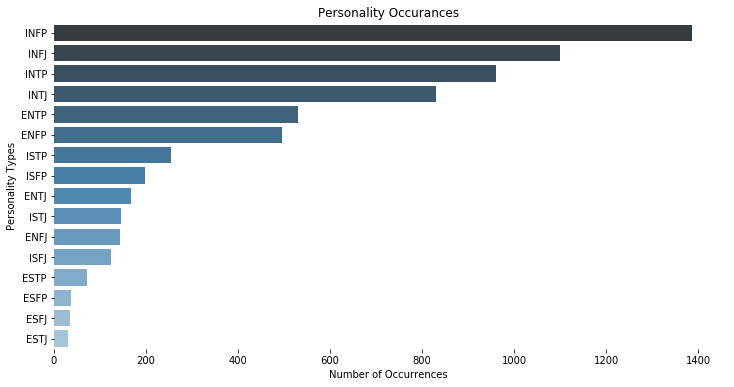

In [119]:
# visualise the occurances/distribution of all the class types.
num_c = train['type'].value_counts()
f, ax = plt.subplots(figsize=(12,6))
sns.barplot( num_c.values, num_c.index, palette="Blues_d")
ax.xaxis.grid(False)
ax.set(xlabel="Number of Occurrences")
ax.set(ylabel="Personality Types")
ax.set(title="Personality Occurances")
sns.despine(trim=True, left=True, bottom=True)

In [0]:
train_type = train[['type']]
test_ID = test['id']
# Now drop the  'Id' colums before the feature engineering process
train.drop(['type'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [121]:
# Put all the features to gether for transformation
post_features = pd.concat([train, test],sort=False).reset_index(drop=True)
post_features.head()

,posts
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,'I'm finding the lack of me in these posts ver...
2,'Good one _____ https://www.youtube.com/wat...
3,"'Dear INTP, I enjoyed our conversation the o..."
4,'You're fired.|||That's another silly misconce...


Here we are going to go through the three steps of Noise Removal, Lexicon Normalization, Object Standardization to get our data into a format that we can work with

REMOVE A REGEX PATTERN

In [122]:
pattern = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
post_features = post_features.replace(to_replace = pattern, value = '', regex = True)
post_features.head()

,posts
0,'||||||enfp and intj moments sportscenter n...
1,'I'm finding the lack of me in these posts ver...
2,"'Good one _____ |||Of course, to which I sa..."
3,"'Dear INTP, I enjoyed our conversation the o..."
4,'You're fired.|||That's another silly misconce...


In [123]:
 import nltk
 nltk.download('stopwords')
 nltk.download('wordnet') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
lem = WordNetLemmatizer()
# ps = PorterStemmer()
corpus =[]
# cleaning text
for i in range(0,len(post_features['posts'])):

    post = re.sub('[^a-zA-Z]', ' ',str(post_features.iloc[i].values)) 
    post = post.lower()
    post = post.split()
#   ps.stem(word)
    stop = stopwords.words('english')
    post = [lem.lemmatize(word, "v") for word in post if not word in stop]
    post = ' '.join(post)
    corpus.append(post)

post_features['posts_clean'] = corpus
post_features.drop(['posts'], axis=1, inplace=True)  

In [125]:
post_features.head()

,posts_clean
0,enfp intj moments sportscenter top ten play pr...
1,find lack post alarm sex bore position often e...
2,good one course say know bless curse absolutel...
3,dear intp enjoy conversation day esoteric gabb...
4,fire another silly misconception approach logi...


**4. Text to Features (Feature Engineering on text data)**

To analyse a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques. Here we are going to use Statistical features. Here text data is quantified directly into numbers using several techniques implemented in this section. Term Frequency – Inverse Document Frequency (TF – IDF) and CountVectorizer

In [126]:
obj = TfidfVectorizer()
post_final_features = obj.fit_transform(post_features['posts_clean'])
print(post_final_features[0])

  (0, 51321)	0.022971753095914153
  (0, 71096)	0.01986360970350271
  (0, 4062)	0.047274026208539495
  (0, 18316)	0.09498645008638615
  (0, 82020)	0.01596645415910647
  (0, 14567)	0.053867316511501555
  (0, 47093)	0.06500552884892956
  (0, 54808)	0.07320038515485536
  (0, 25468)	0.06060195869391936
  (0, 7586)	0.027894891259623238
  (0, 58435)	0.04538429404512145
  (0, 7408)	0.021206654335971402
  (0, 69879)	0.029399599740099487
  (0, 1498)	0.027917308013944236
  (0, 84642)	0.02183200436723868
  (0, 70189)	0.028175502555248942
  (0, 60135)	0.043232650308424714
  (0, 25455)	0.041018094693615934
  (0, 1400)	0.032429904556302395
  (0, 49908)	0.02854634446563593
  (0, 65751)	0.024802541253978988
  (0, 53456)	0.027598014612381074
  (0, 1600)	0.06274183478703248
  (0, 84762)	0.04596298373355101
  (0, 71609)	0.06592524469693782
  :	:
  (0, 51400)	0.03262506371186185
  (0, 72390)	0.059059136897429226
  (0, 14036)	0.052354713799169145
  (0, 25335)	0.04572854782274967
  (0, 58495)	0.0187643849744

creating target variables 

In [127]:
# create our target variables
pd.options.mode.chained_assignment = None

train_type['I-E'] = train_type['type'].astype(str).str[0]
train_type['I-E'] = train_type['I-E'].map({"I": 0, "E": 1})
train_type['S-N'] = train_type['type'].astype(str).str[1]
train_type['S-N'] = train_type['S-N'].map({"S": 0, "N": 1})
train_type['F-T'] = train_type['type'].astype(str).str[2]
train_type['F-T'] = train_type['F-T'].map({"F": 0, "T": 1})
train_type['P-J'] = train_type['type'].astype(str).str[3]
train_type['P-J'] = train_type['P-J'].map({"P": 0, "J": 1})
train_type.drop('type', axis=1, inplace=True) 
y = train_type
print(y[:5])

   I-E  S-N  F-T  P-J
0    0    1    0    1
1    1    1    1    0
2    0    1    1    0
3    0    1    1    1
4    1    1    1    1


In [128]:
y = np.array(y)
print(y[0:5])

[[0 1 0 1]
 [1 1 1 0]
 [0 1 1 0]
 [0 1 1 1]
 [1 1 1 1]]


Separating the data into a proper training(X,y) and the testing(X_final_test) set.

In [129]:
# Spliting the data back to train(X,y) and test(X_sub)
X = post_final_features[:len(y), :]
X_final_test = post_final_features[len(y):, :]
print('Features size for train(X,y) and test(X_final_test):')
print('X', X.shape, 'y', y.shape, 'X_final_test', X_final_test.shape)

Features size for train(X,y) and test(X_final_test):
X (6506, 85722) y (6506, 4) X_final_test (2169, 85722)


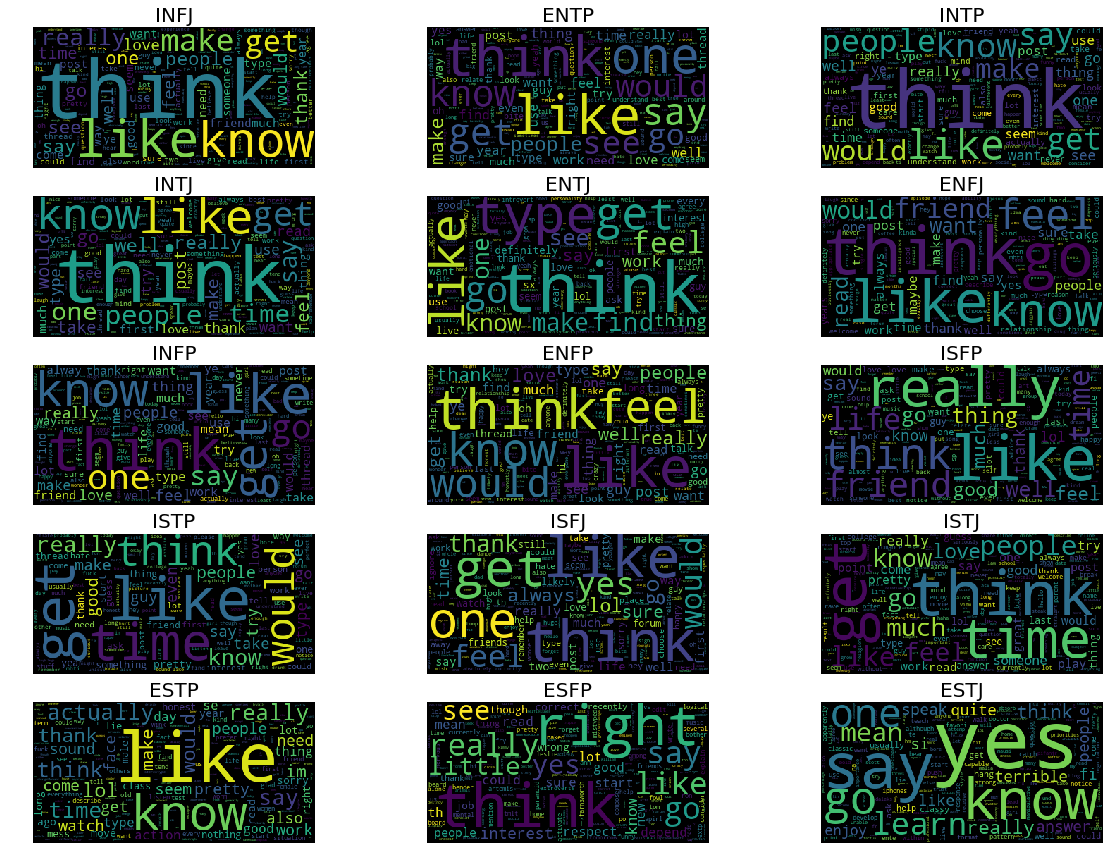

In [132]:
# wordcloud of the most frequently used words by each personality
from wordcloud import WordCloud, STOPWORDS
yc['posts_clean'] = post_features['posts_clean']
labels = yc['type'].unique()
row, col = 5, 3
wc = WordCloud(stopwords = ['infj','entp','intp','intj', 'isfps','istps','isfjs','istjs',
                             'entjs','enfjs','infps','enfps','entj','enfj','infp','enfp',
                             'estps','esfps','estjs','esfjs','isfp','istp','isfj','istj',
                             'estp','esfp','estj','esfj','infjs','entps','intps','intjs'])
fig, ax = plt.subplots(5, 3, figsize=(20,15))
for i in range(5):
    for j in range(3):
        c_type = labels[i*col+j]
        c_ax = ax[i][j]
        df = yc[yc['type'] == c_type]
        wordc = wc.generate(df['posts_clean'].to_string())
        c_ax.imshow(wordc)
        c_ax.axis('off')
        c_ax.set_title(label=c_type,fontdict = {'fontsize': 20})


**5. Text Classification**

Text classification, in common words is defined as a technique to systematically classify a text object (document or sentence) in one of the fixed category. In these case we have 8 categories((I-E), (S-N), (F-T), (P-J)) that we are classifiying


*   **Model Bulding and Validation**




In [0]:
# Predicting model
from sklearn.neighbors import KNeighborsClassifier
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [137]:
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=3,
                                                   p=2, weights='uniform'),
                    n_jobs=None)

In [0]:
y_pred = model.predict(X_test)

In [139]:
# performance matrics and model eveluation.
print(classification_report(y_test, y_pred, target_names=['Mind', 'Energy', 'Nature', 'Tactics']))

              precision    recall  f1-score   support

        Mind       0.50      0.39      0.44       303
      Energy       0.89      0.95      0.92      1113
      Nature       0.74      0.41      0.52       590
     Tactics       0.54      0.56      0.55       512

   micro avg       0.75      0.68      0.71      2518
   macro avg       0.67      0.58      0.61      2518
weighted avg       0.74      0.68      0.69      2518
 samples avg       0.76      0.69      0.69      2518





*   **Other Models Used**
    

* **Cross-validation**







In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
my_pipeline = make_pipeline(RandomForestRegressor())

In [0]:
model = my_pipeline

In [146]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [0]:
y_pred = model.predict(X_final_test)

In [0]:
y_predict = np.around(y_pred, 0).astype(int)

In [164]:
y_predict[0:5]

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1]])

In [175]:
# format submission of the predicted classes
submission = pd.DataFrame({'id' : np.array(test_ID),'mind' : y_predict[:,0], 
                           'energy' : y_predict[:,1], 'nature' : y_predict[:,2], 
                           'tactics' : y_predict[:,3]})
print('Save submission')

Save submission


In [176]:
submission.to_csv("second_submission.csv", index=False)
submission.head()

,id,mind,energy,nature,tactics
0,1,0,1,0,0
1,2,0,1,0,0
2,3,0,1,1,1
3,4,0,1,0,0
4,5,0,1,0,1


In [0]:
#AnotherMethodAttempt
# from sklearn.naive_bayes import MultinomialNB
# model = OneVsRestClassifier(MultinomialNB())

In [0]:
from sklearn.neighbors import KNeighborsClassifier
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))



*   **Final Model**




In [0]:
# model = OneVsRestClassifier(LogisticRegressionCV( Cs=20,l1_ratios=[1],penalty='elasticnet',solver = 'saga',
#                                                         multi_class = 'multinomial', cv=5), n_jobs =-1)

In [168]:
model.fit(X, y)

OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=3,
                                                   p=2, weights='uniform'),
                    n_jobs=None)

In [0]:
y_predicted = model.predict(X_final_test)

In [170]:
# Final model results
y_predicted[0:5]

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1]])

Visualising Accuracy and Distribution of each class/category of our test data.

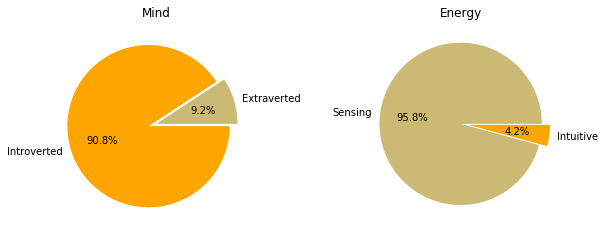

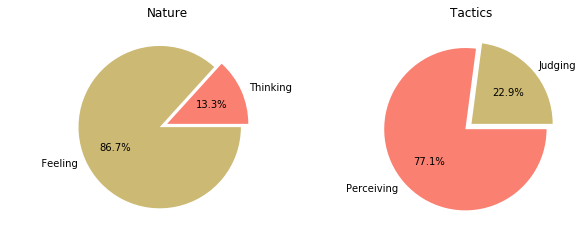

In [171]:
# Plot the accuracy for each classifier
f, ax = plt.subplots(figsize=(20, 10))
sns.set_color_codes(palette='deep')
plt.subplots_adjust(wspace = 0.5)
ax = plt.subplot(2, 4, 1)
plt.pie([sum(y_predicted[:,0]), len(y_predicted[:,0]) - sum(y_predicted[:,0])],
        labels = ['Extraverted', 'Introverted'],explode = (0, 0.1),autopct='%1.1f%%', colors=['y','orange'])
ax.set(title="Mind")

ax = plt.subplot(2, 4, 2)
plt.pie([sum(y_predicted[:,1]), len(y_predicted[:,1]) - sum(y_predicted[:,1])], 
        labels = ['Sensing', 'Intuitive'],explode = (0, 0.1),autopct='%1.1f%%', colors=['y','orange'])
ax.set(title="Energy")

f, ax2 = plt.subplots(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.5)

ax2 = plt.subplot(2, 4, 1)
plt.pie([sum(y_predicted[:,2]), len(y_predicted[:,2]) - sum(y_predicted[:,2])], 
        labels = ['Thinking', '           Feeling'],explode = (0, 0.1),autopct='%1.1f%%', colors=['salmon','y'])
ax2.set(title="Nature")

ax2 = plt.subplot(2, 4, 2)
plt.pie([sum(y_predicted[:,3]),  len(y_predicted[:,3]) - sum(y_predicted[:,3])], 
        labels = ['Judging', 'Perceiving'], explode = (0, 0.1), autopct='%1.1f%%', colors=['y','salmon'])
ax2.set(title="Tactics")
plt.show()

**6. Submission** 

predict results of a test

In [172]:
# format submission of the predicted classes
submission = pd.DataFrame({'id' : np.array(test_ID),'mind' : y_predicted[:,0], 
                           'energy' : y_predicted[:,1], 'nature' : y_predicted[:,2], 
                           'tactics' : y_predicted[:,3]})
print('Save submission')

Save submission


In [173]:
submission.to_csv("new_submission.csv", index=False)
submission.head()

,id,mind,energy,nature,tactics
0,1,0,1,0,0
1,2,0,1,0,0
2,3,0,1,0,0
3,4,0,1,0,0
4,5,0,1,0,1
